# ML Experiments in "Algebraic and Geometric Models for Space Networks"

In [1]:
from os_utilities import make_folder

from orb_builder import *
import soap_utilities as su
import report_parser as rp
import slice_analysis_nx as sanx # network x based
import slice_analysis as sagt # graph-tools based
from distances_tvg import *
from matrix import *
from ml_knn import *
from tle_utilities import starlink_exclude
from visualization import save_heatmap_gif

from tqdm import tqdm
from datetime import datetime
import itertools


In [2]:
folder_base = f"./outputs/experiments"
make_folder(folder_base)

date = datetime.now()

starlink = build_satellites_csv("starlink")
exclude_list = starlink_exclude(date, 200, 800)
starlink = list(filter(lambda sat : sat['object_name'] not in exclude_list, starlink))

moon_sats = get_moon_platforms()
mars_sats = get_mars_platforms()
ground = [
    create_ground_object_dictionary("Ground-Albany", 42.685012663456163, -73.82479012295363, 0),
    create_ground_object_dictionary("Ground-Sydney", -33.868888888888889, 151.20939697339508, 0)
]
norad = build_satellites_from_tle("./sources/tdrss.tle")

def generate_orb_files(folder_name, name, satellites, date):
        save_to_outputs_file(
                generate_orb(satellites, name, date),
                f"experiments/{folder_name}/{name}", "orb")
        return name + ".orb"

## Average of $L(\mu^k)(i, j) = $ sum of intervals in entry $(i, j)$

### KNN on Earth/Moon and Earth/Mars Simulations (Single Day)

Running Lifetime Matrix Simulations on Date = 2023-04-29 13:32:21.719710
Generating ORB Files
Running SOAP on ORB files


57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)
31:84: execution error: System Events got an error: Can’t set application process "SOAP" to false. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)
31:84: execution error: System Events got an error: Can’t set application process "SOAP" to false. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)
31:84: execution error: System Events got an error: Can’t set application process "SOAP" to false. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)


Constructing Matrices from ORB Files


100%|██████████| 30/30 [00:01<00:00, 25.29it/s]


Average Dimension of 5-Satellite TVG Matrices is 4.633333333333334
The maximum diameter over 30 is 4


100%|██████████| 30/30 [00:01<00:00, 19.16it/s]


Average Dimension of 10-Satellite TVG Matrices is 9.9
The maximum diameter over 30 is 7


100%|██████████| 30/30 [00:03<00:00,  9.43it/s]


Average Dimension of 15-Satellite TVG Matrices is 14.966666666666667
The maximum diameter over 30 is 12


100%|██████████| 30/30 [00:06<00:00,  4.63it/s]


Average Dimension of 20-Satellite TVG Matrices is 19.833333333333332
The maximum diameter over 30 is 14


100%|██████████| 30/30 [03:46<00:00,  7.54s/it]


Average Dimension of 50-Satellite TVG Matrices is 49.53333333333333
The maximum diameter over 30 is 16


100%|██████████| 30/30 [14:00<00:00, 28.03s/it]


Average Dimension of 70-Satellite TVG Matrices is 69.63333333333334
The maximum diameter over 30 is 12


100%|██████████| 30/30 [1:03:23<00:00, 126.79s/it]


Average Dimension of 100-Satellite TVG Matrices is 99.5
The maximum diameter over 30 is 10
Calculating Walks
Calculating walks up to k = 16
Calculating Walks for 30 5-Satellite Systems


 10%|█         | 3/30 [00:00<00:01, 21.96it/s]

len(data_list) = 16 | frame_count = 2
len(data_list) = 16 | frame_count = 3
len(data_list) = 16 | frame_count = 2
len(data_list) = 16 | frame_count = 3


 20%|██        | 6/30 [00:00<00:01, 16.45it/s]

len(data_list) = 16 | frame_count = 3
truncated frame_count=3 to 2
len(data_list) = 16 | frame_count = 2
len(data_list) = 16 | frame_count = 3


 30%|███       | 9/30 [00:00<00:01, 18.40it/s]

len(data_list) = 16 | frame_count = 2
truncated frame_count=2 to 1


 37%|███▋      | 11/30 [00:00<00:01, 18.27it/s]

len(data_list) = 16 | frame_count = 4
truncated frame_count=4 to 3
len(data_list) = 16 | frame_count = 3


 43%|████▎     | 13/30 [00:00<00:00, 17.07it/s]

len(data_list) = 16 | frame_count = 3
truncated frame_count=3 to 2
len(data_list) = 16 | frame_count = 2


 50%|█████     | 15/30 [00:00<00:00, 16.13it/s]

len(data_list) = 16 | frame_count = 2
len(data_list) = 16 | frame_count = 2


 57%|█████▋    | 17/30 [00:01<00:00, 15.39it/s]

len(data_list) = 16 | frame_count = 3


 63%|██████▎   | 19/30 [00:01<00:00, 15.43it/s]

len(data_list) = 16 | frame_count = 4
truncated frame_count=4 to 3
len(data_list) = 16 | frame_count = 2
len(data_list) = 16 | frame_count = 3
truncated frame_count=3 to 2
len(data_list) = 16 | frame_count = 3


 83%|████████▎ | 25/30 [00:01<00:00, 18.33it/s]

len(data_list) = 16 | frame_count = 3
len(data_list) = 16 | frame_count = 3
truncated frame_count=3 to 2
len(data_list) = 16 | frame_count = 3
len(data_list) = 16 | frame_count = 2


100%|██████████| 30/30 [00:01<00:00, 18.24it/s]


len(data_list) = 16 | frame_count = 3
truncated frame_count=3 to 2
Calculating Walks for 30 10-Satellite Systems


  3%|▎         | 1/30 [00:00<00:10,  2.89it/s]

len(data_list) = 16 | frame_count = 5


  7%|▋         | 2/30 [00:00<00:07,  3.51it/s]

len(data_list) = 16 | frame_count = 4


 10%|█         | 3/30 [00:00<00:08,  3.25it/s]

len(data_list) = 16 | frame_count = 6


 13%|█▎        | 4/30 [00:01<00:08,  3.24it/s]

len(data_list) = 16 | frame_count = 6


 17%|█▋        | 5/30 [00:01<00:09,  2.59it/s]

len(data_list) = 16 | frame_count = 5


 20%|██        | 6/30 [00:02<00:08,  2.70it/s]

len(data_list) = 16 | frame_count = 7


 23%|██▎       | 7/30 [00:02<00:07,  2.92it/s]

len(data_list) = 16 | frame_count = 4


 27%|██▋       | 8/30 [00:02<00:08,  2.67it/s]

len(data_list) = 16 | frame_count = 6


 30%|███       | 9/30 [00:03<00:08,  2.41it/s]

len(data_list) = 16 | frame_count = 6


 33%|███▎      | 10/30 [00:03<00:07,  2.79it/s]

len(data_list) = 16 | frame_count = 4


 37%|███▋      | 11/30 [00:03<00:06,  2.76it/s]

len(data_list) = 16 | frame_count = 6
len(data_list) = 16 | frame_count = 3


 43%|████▎     | 13/30 [00:04<00:05,  3.29it/s]

len(data_list) = 16 | frame_count = 5


 47%|████▋     | 14/30 [00:04<00:04,  3.34it/s]

len(data_list) = 16 | frame_count = 4


 50%|█████     | 15/30 [00:05<00:05,  2.69it/s]

len(data_list) = 16 | frame_count = 5


 53%|█████▎    | 16/30 [00:05<00:04,  3.11it/s]

len(data_list) = 16 | frame_count = 4


 57%|█████▋    | 17/30 [00:05<00:05,  2.59it/s]

len(data_list) = 16 | frame_count = 6


 60%|██████    | 18/30 [00:06<00:04,  2.77it/s]

len(data_list) = 16 | frame_count = 5


 63%|██████▎   | 19/30 [00:06<00:03,  3.07it/s]

len(data_list) = 16 | frame_count = 5


 67%|██████▋   | 20/30 [00:06<00:02,  3.40it/s]

len(data_list) = 16 | frame_count = 4


 70%|███████   | 21/30 [00:06<00:02,  3.53it/s]

len(data_list) = 16 | frame_count = 5


 73%|███████▎  | 22/30 [00:07<00:02,  3.31it/s]

len(data_list) = 16 | frame_count = 5


 77%|███████▋  | 23/30 [00:07<00:02,  3.29it/s]

len(data_list) = 16 | frame_count = 5


 80%|████████  | 24/30 [00:08<00:01,  3.03it/s]

len(data_list) = 16 | frame_count = 5
len(data_list) = 16 | frame_count = 3


 87%|████████▋ | 26/30 [00:08<00:01,  3.31it/s]

len(data_list) = 16 | frame_count = 5


 90%|█████████ | 27/30 [00:08<00:00,  3.03it/s]

len(data_list) = 16 | frame_count = 6


 93%|█████████▎| 28/30 [00:09<00:00,  2.16it/s]

len(data_list) = 16 | frame_count = 6
truncated frame_count=6 to 5


 97%|█████████▋| 29/30 [00:10<00:00,  2.27it/s]

len(data_list) = 16 | frame_count = 6


100%|██████████| 30/30 [00:10<00:00,  2.90it/s]


len(data_list) = 16 | frame_count = 4
Calculating Walks for 30 15-Satellite Systems


  3%|▎         | 1/30 [00:01<00:35,  1.23s/it]

len(data_list) = 16 | frame_count = 8


  7%|▋         | 2/30 [00:02<00:39,  1.42s/it]

len(data_list) = 16 | frame_count = 6


 10%|█         | 3/30 [00:04<00:41,  1.55s/it]

len(data_list) = 16 | frame_count = 7


 13%|█▎        | 4/30 [00:05<00:33,  1.27s/it]

len(data_list) = 16 | frame_count = 7


 17%|█▋        | 5/30 [00:06<00:31,  1.26s/it]

len(data_list) = 16 | frame_count = 8


 20%|██        | 6/30 [00:08<00:31,  1.33s/it]

len(data_list) = 16 | frame_count = 9


 23%|██▎       | 7/30 [00:09<00:28,  1.22s/it]

len(data_list) = 16 | frame_count = 6


 27%|██▋       | 8/30 [00:10<00:25,  1.16s/it]

len(data_list) = 16 | frame_count = 7


 30%|███       | 9/30 [00:11<00:23,  1.10s/it]

len(data_list) = 16 | frame_count = 7


 33%|███▎      | 10/30 [00:12<00:21,  1.09s/it]

len(data_list) = 16 | frame_count = 9


 37%|███▋      | 11/30 [00:13<00:21,  1.15s/it]

len(data_list) = 16 | frame_count = 8


 40%|████      | 12/30 [00:14<00:21,  1.18s/it]

len(data_list) = 16 | frame_count = 9


 43%|████▎     | 13/30 [00:15<00:20,  1.22s/it]

len(data_list) = 16 | frame_count = 7


 47%|████▋     | 14/30 [00:17<00:20,  1.28s/it]

len(data_list) = 16 | frame_count = 9


 50%|█████     | 15/30 [00:18<00:19,  1.32s/it]

len(data_list) = 16 | frame_count = 10


 53%|█████▎    | 16/30 [00:19<00:17,  1.26s/it]

len(data_list) = 16 | frame_count = 9


 57%|█████▋    | 17/30 [00:21<00:18,  1.45s/it]

len(data_list) = 16 | frame_count = 10
truncated frame_count=10 to 9


 60%|██████    | 18/30 [00:23<00:17,  1.44s/it]

len(data_list) = 16 | frame_count = 8


 63%|██████▎   | 19/30 [00:24<00:16,  1.53s/it]

len(data_list) = 16 | frame_count = 12


 67%|██████▋   | 20/30 [00:26<00:15,  1.51s/it]

len(data_list) = 16 | frame_count = 8


 70%|███████   | 21/30 [00:27<00:12,  1.43s/it]

len(data_list) = 16 | frame_count = 9


 73%|███████▎  | 22/30 [00:28<00:10,  1.28s/it]

len(data_list) = 16 | frame_count = 7


 77%|███████▋  | 23/30 [00:29<00:09,  1.31s/it]

len(data_list) = 16 | frame_count = 8


 80%|████████  | 24/30 [00:31<00:07,  1.24s/it]

len(data_list) = 16 | frame_count = 11


 83%|████████▎ | 25/30 [00:32<00:05,  1.18s/it]

len(data_list) = 16 | frame_count = 7


 87%|████████▋ | 26/30 [00:33<00:05,  1.40s/it]

len(data_list) = 16 | frame_count = 10
truncated frame_count=10 to 9


 90%|█████████ | 27/30 [00:35<00:03,  1.32s/it]

len(data_list) = 16 | frame_count = 9


 93%|█████████▎| 28/30 [00:36<00:02,  1.31s/it]

len(data_list) = 16 | frame_count = 10


 97%|█████████▋| 29/30 [00:37<00:01,  1.23s/it]

len(data_list) = 16 | frame_count = 7


100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


len(data_list) = 16 | frame_count = 8
Calculating Walks for 30 20-Satellite Systems


  3%|▎         | 1/30 [00:05<02:28,  5.11s/it]

len(data_list) = 16 | frame_count = 11


  7%|▋         | 2/30 [00:08<02:02,  4.38s/it]

len(data_list) = 16 | frame_count = 12


 10%|█         | 3/30 [00:13<01:53,  4.22s/it]

len(data_list) = 16 | frame_count = 13


 13%|█▎        | 4/30 [00:17<01:50,  4.26s/it]

len(data_list) = 16 | frame_count = 13


 17%|█▋        | 5/30 [00:20<01:36,  3.88s/it]

len(data_list) = 16 | frame_count = 12


 20%|██        | 6/30 [00:23<01:27,  3.65s/it]

len(data_list) = 16 | frame_count = 11
truncated frame_count=11 to 10


 23%|██▎       | 7/30 [00:27<01:27,  3.82s/it]

len(data_list) = 16 | frame_count = 12


 27%|██▋       | 8/30 [00:30<01:18,  3.56s/it]

len(data_list) = 16 | frame_count = 12


 30%|███       | 9/30 [00:33<01:08,  3.25s/it]

len(data_list) = 16 | frame_count = 11


 33%|███▎      | 10/30 [00:38<01:18,  3.93s/it]

len(data_list) = 16 | frame_count = 11


 37%|███▋      | 11/30 [00:42<01:13,  3.85s/it]

len(data_list) = 16 | frame_count = 13


 40%|████      | 12/30 [00:45<01:05,  3.65s/it]

len(data_list) = 16 | frame_count = 11


 43%|████▎     | 13/30 [00:49<01:00,  3.57s/it]

len(data_list) = 16 | frame_count = 13


 47%|████▋     | 14/30 [00:51<00:51,  3.23s/it]

len(data_list) = 16 | frame_count = 11
len(data_list) = 16 | frame_count = 14


 53%|█████▎    | 16/30 [00:59<00:49,  3.53s/it]

len(data_list) = 16 | frame_count = 12


 57%|█████▋    | 17/30 [01:03<00:48,  3.70s/it]

len(data_list) = 16 | frame_count = 14
truncated frame_count=14 to 13


 60%|██████    | 18/30 [01:06<00:43,  3.61s/it]

len(data_list) = 16 | frame_count = 10


 63%|██████▎   | 19/30 [01:11<00:41,  3.81s/it]

len(data_list) = 16 | frame_count = 11


 67%|██████▋   | 20/30 [01:14<00:35,  3.58s/it]

len(data_list) = 16 | frame_count = 8


 70%|███████   | 21/30 [01:17<00:32,  3.57s/it]

len(data_list) = 16 | frame_count = 11


 73%|███████▎  | 22/30 [01:20<00:26,  3.31s/it]

len(data_list) = 16 | frame_count = 12


 77%|███████▋  | 23/30 [01:24<00:23,  3.41s/it]

len(data_list) = 16 | frame_count = 11


 80%|████████  | 24/30 [01:27<00:20,  3.45s/it]

len(data_list) = 16 | frame_count = 13


 83%|████████▎ | 25/30 [01:31<00:18,  3.71s/it]

len(data_list) = 16 | frame_count = 12
truncated frame_count=12 to 11


 87%|████████▋ | 26/30 [01:35<00:14,  3.74s/it]

len(data_list) = 16 | frame_count = 10


 90%|█████████ | 27/30 [01:38<00:10,  3.45s/it]

len(data_list) = 16 | frame_count = 11


 93%|█████████▎| 28/30 [01:42<00:07,  3.66s/it]

len(data_list) = 16 | frame_count = 10


 97%|█████████▋| 29/30 [01:45<00:03,  3.46s/it]

len(data_list) = 16 | frame_count = 12
truncated frame_count=12 to 11


100%|██████████| 30/30 [01:49<00:00,  3.65s/it]


len(data_list) = 16 | frame_count = 12
Calculating Walks for 30 50-Satellite Systems


  0%|          | 0/30 [00:00<?, ?it/s]

len(data_list) = 16 | frame_count = 13
truncated frame_count=13 to 12


  3%|▎         | 1/30 [00:49<23:48, 49.26s/it]

len(data_list) = 16 | frame_count = 14
truncated frame_count=14 to 13


  7%|▋         | 2/30 [01:44<24:33, 52.63s/it]

len(data_list) = 16 | frame_count = 14
truncated frame_count=14 to 13


 10%|█         | 3/30 [02:35<23:28, 52.15s/it]

len(data_list) = 16 | frame_count = 12
truncated frame_count=12 to 11


 13%|█▎        | 4/30 [03:21<21:25, 49.43s/it]

len(data_list) = 16 | frame_count = 15
truncated frame_count=15 to 14


 17%|█▋        | 5/30 [04:07<20:09, 48.37s/it]

len(data_list) = 16 | frame_count = 13
truncated frame_count=13 to 12


 20%|██        | 6/30 [04:54<19:05, 47.73s/it]

len(data_list) = 16 | frame_count = 10
truncated frame_count=10 to 9


 23%|██▎       | 7/30 [05:39<17:59, 46.95s/it]

len(data_list) = 16 | frame_count = 13


 27%|██▋       | 8/30 [06:23<16:53, 46.07s/it]

len(data_list) = 16 | frame_count = 14
truncated frame_count=14 to 13


 30%|███       | 9/30 [07:11<16:19, 46.65s/it]

len(data_list) = 16 | frame_count = 13


 33%|███▎      | 10/30 [08:06<16:22, 49.12s/it]

len(data_list) = 16 | frame_count = 16
truncated frame_count=16 to 15


 37%|███▋      | 11/30 [08:57<15:47, 49.89s/it]

len(data_list) = 16 | frame_count = 16


 40%|████      | 12/30 [09:50<15:10, 50.60s/it]

len(data_list) = 16 | frame_count = 14
truncated frame_count=14 to 13


 43%|████▎     | 13/30 [10:40<14:21, 50.67s/it]

len(data_list) = 16 | frame_count = 13
truncated frame_count=13 to 12


 47%|████▋     | 14/30 [11:24<12:56, 48.54s/it]

len(data_list) = 16 | frame_count = 13


 50%|█████     | 15/30 [12:10<11:56, 47.78s/it]

len(data_list) = 16 | frame_count = 15
truncated frame_count=15 to 14


 53%|█████▎    | 16/30 [12:58<11:10, 47.89s/it]

len(data_list) = 16 | frame_count = 16
truncated frame_count=16 to 15


 57%|█████▋    | 17/30 [13:42<10:06, 46.69s/it]

len(data_list) = 16 | frame_count = 15
truncated frame_count=15 to 14


 60%|██████    | 18/30 [14:37<09:48, 49.06s/it]

len(data_list) = 16 | frame_count = 16


 63%|██████▎   | 19/30 [15:27<09:03, 49.44s/it]

len(data_list) = 16 | frame_count = 16
truncated frame_count=16 to 15


 67%|██████▋   | 20/30 [16:21<08:26, 50.68s/it]

len(data_list) = 16 | frame_count = 15
truncated frame_count=15 to 14


 70%|███████   | 21/30 [17:17<07:50, 52.31s/it]

len(data_list) = 16 | frame_count = 15
truncated frame_count=15 to 14


 73%|███████▎  | 22/30 [18:01<06:38, 49.84s/it]

len(data_list) = 16 | frame_count = 16
truncated frame_count=16 to 15


 77%|███████▋  | 23/30 [18:49<05:45, 49.34s/it]

len(data_list) = 16 | frame_count = 12
truncated frame_count=12 to 11


 80%|████████  | 24/30 [19:34<04:49, 48.17s/it]

len(data_list) = 16 | frame_count = 13


 83%|████████▎ | 25/30 [20:21<03:58, 47.63s/it]

len(data_list) = 16 | frame_count = 13


 87%|████████▋ | 26/30 [21:04<03:05, 46.34s/it]

len(data_list) = 16 | frame_count = 14


 90%|█████████ | 27/30 [21:53<02:21, 47.23s/it]

len(data_list) = 16 | frame_count = 14
truncated frame_count=14 to 13


 93%|█████████▎| 28/30 [22:35<01:31, 45.69s/it]

len(data_list) = 16 | frame_count = 14
truncated frame_count=14 to 13


 97%|█████████▋| 29/30 [23:22<00:46, 46.07s/it]

len(data_list) = 16 | frame_count = 11
truncated frame_count=11 to 10


100%|██████████| 30/30 [24:04<00:00, 48.16s/it]


Calculating Walks for 30 70-Satellite Systems


  0%|          | 0/30 [00:00<?, ?it/s]

len(data_list) = 16 | frame_count = 10
truncated frame_count=10 to 9


  3%|▎         | 1/30 [01:45<50:59, 105.49s/it]

len(data_list) = 16 | frame_count = 12
truncated frame_count=12 to 11


  7%|▋         | 2/30 [03:41<52:03, 111.57s/it]

len(data_list) = 16 | frame_count = 11
truncated frame_count=11 to 10


 10%|█         | 3/30 [05:31<49:50, 110.76s/it]

len(data_list) = 16 | frame_count = 11
truncated frame_count=11 to 10


 17%|█▋        | 5/30 [08:55<43:53, 105.32s/it]

len(data_list) = 16 | frame_count = 8
truncated frame_count=8 to 7
len(data_list) = 16 | frame_count = 10
truncated frame_count=10 to 9


 20%|██        | 6/30 [10:53<43:52, 109.70s/it]

len(data_list) = 16 | frame_count = 10
truncated frame_count=10 to 9


 23%|██▎       | 7/30 [12:34<40:57, 106.86s/it]

len(data_list) = 16 | frame_count = 9
truncated frame_count=9 to 8


 27%|██▋       | 8/30 [14:17<38:43, 105.60s/it]

len(data_list) = 16 | frame_count = 12
truncated frame_count=12 to 11


 30%|███       | 9/30 [16:11<37:54, 108.29s/it]

len(data_list) = 16 | frame_count = 11
truncated frame_count=11 to 10


 33%|███▎      | 10/30 [17:59<36:07, 108.37s/it]

len(data_list) = 16 | frame_count = 10
truncated frame_count=10 to 9


 37%|███▋      | 11/30 [19:51<34:37, 109.35s/it]

len(data_list) = 16 | frame_count = 10
truncated frame_count=10 to 9


 40%|████      | 12/30 [21:52<33:51, 112.88s/it]

len(data_list) = 16 | frame_count = 9
truncated frame_count=9 to 8


 43%|████▎     | 13/30 [23:35<31:10, 110.01s/it]

len(data_list) = 16 | frame_count = 12
truncated frame_count=12 to 11


 50%|█████     | 15/30 [27:17<27:31, 110.10s/it]

len(data_list) = 16 | frame_count = 8
truncated frame_count=8 to 7
len(data_list) = 16 | frame_count = 9
truncated frame_count=9 to 8


 53%|█████▎    | 16/30 [29:06<25:38, 109.89s/it]

len(data_list) = 16 | frame_count = 10
truncated frame_count=10 to 9


 57%|█████▋    | 17/30 [30:57<23:50, 110.05s/it]

len(data_list) = 16 | frame_count = 10
truncated frame_count=10 to 9


 60%|██████    | 18/30 [32:46<21:57, 109.80s/it]

len(data_list) = 16 | frame_count = 10
truncated frame_count=10 to 9


 63%|██████▎   | 19/30 [34:37<20:12, 110.21s/it]

len(data_list) = 16 | frame_count = 10
truncated frame_count=10 to 9


 67%|██████▋   | 20/30 [36:22<18:06, 108.61s/it]

len(data_list) = 16 | frame_count = 10
truncated frame_count=10 to 9


 73%|███████▎  | 22/30 [40:04<14:39, 109.95s/it]

len(data_list) = 16 | frame_count = 8
truncated frame_count=8 to 7
len(data_list) = 16 | frame_count = 9
truncated frame_count=9 to 8


 77%|███████▋  | 23/30 [41:49<12:38, 108.38s/it]

len(data_list) = 16 | frame_count = 11
truncated frame_count=11 to 10


 80%|████████  | 24/30 [43:36<10:47, 107.91s/it]

len(data_list) = 16 | frame_count = 9
truncated frame_count=9 to 8


 83%|████████▎ | 25/30 [45:24<08:59, 107.95s/it]

len(data_list) = 16 | frame_count = 11
truncated frame_count=11 to 10


 87%|████████▋ | 26/30 [47:11<07:10, 107.68s/it]

len(data_list) = 16 | frame_count = 9
truncated frame_count=9 to 8


 90%|█████████ | 27/30 [49:02<05:25, 108.60s/it]

len(data_list) = 16 | frame_count = 9
truncated frame_count=9 to 8


 93%|█████████▎| 28/30 [50:55<03:40, 110.08s/it]

len(data_list) = 16 | frame_count = 10
truncated frame_count=10 to 9


 97%|█████████▋| 29/30 [52:47<01:50, 110.54s/it]

len(data_list) = 16 | frame_count = 10
truncated frame_count=10 to 9


100%|██████████| 30/30 [54:40<00:00, 109.35s/it]


Calculating Walks for 30 100-Satellite Systems


  0%|          | 0/30 [00:00<?, ?it/s]

len(data_list) = 16 | frame_count = 7
truncated frame_count=7 to 6


  3%|▎         | 1/30 [04:56<2:23:17, 296.48s/it]

len(data_list) = 16 | frame_count = 8
truncated frame_count=8 to 7


  7%|▋         | 2/30 [10:07<2:22:22, 305.07s/it]

len(data_list) = 16 | frame_count = 8
truncated frame_count=8 to 7


 10%|█         | 3/30 [14:59<2:14:34, 299.06s/it]

len(data_list) = 16 | frame_count = 8
truncated frame_count=8 to 7


 13%|█▎        | 4/30 [19:55<2:09:06, 297.94s/it]

len(data_list) = 16 | frame_count = 7
truncated frame_count=7 to 6


 17%|█▋        | 5/30 [24:56<2:04:32, 298.89s/it]

len(data_list) = 16 | frame_count = 7
truncated frame_count=7 to 6


 20%|██        | 6/30 [30:00<2:00:13, 300.55s/it]

len(data_list) = 16 | frame_count = 7
truncated frame_count=7 to 6


 23%|██▎       | 7/30 [34:47<1:53:36, 296.38s/it]

len(data_list) = 16 | frame_count = 8
truncated frame_count=8 to 7


 27%|██▋       | 8/30 [39:44<1:48:44, 296.55s/it]

len(data_list) = 16 | frame_count = 7
truncated frame_count=7 to 6


 30%|███       | 9/30 [44:50<1:44:50, 299.55s/it]

len(data_list) = 16 | frame_count = 8
truncated frame_count=8 to 7


 33%|███▎      | 10/30 [49:51<1:39:57, 299.90s/it]

len(data_list) = 16 | frame_count = 7
truncated frame_count=7 to 6


 37%|███▋      | 11/30 [54:51<1:34:55, 299.76s/it]

len(data_list) = 16 | frame_count = 7
truncated frame_count=7 to 6


 40%|████      | 12/30 [59:57<1:30:34, 301.92s/it]

len(data_list) = 16 | frame_count = 10
truncated frame_count=10 to 9


 43%|████▎     | 13/30 [1:05:24<1:27:41, 309.48s/it]

len(data_list) = 16 | frame_count = 8
truncated frame_count=8 to 7


 47%|████▋     | 14/30 [1:10:40<1:23:03, 311.47s/it]

len(data_list) = 16 | frame_count = 8
truncated frame_count=8 to 7


 50%|█████     | 15/30 [1:15:41<1:17:04, 308.29s/it]

len(data_list) = 16 | frame_count = 7
truncated frame_count=7 to 6


 53%|█████▎    | 16/30 [1:20:45<1:11:35, 306.81s/it]

len(data_list) = 16 | frame_count = 7
truncated frame_count=7 to 6


 57%|█████▋    | 17/30 [1:25:46<1:06:07, 305.16s/it]

len(data_list) = 16 | frame_count = 7
truncated frame_count=7 to 6


 60%|██████    | 18/30 [1:30:53<1:01:08, 305.73s/it]

len(data_list) = 16 | frame_count = 8
truncated frame_count=8 to 7


 63%|██████▎   | 19/30 [1:35:56<55:52, 304.80s/it]  

len(data_list) = 16 | frame_count = 7
truncated frame_count=7 to 6


 67%|██████▋   | 20/30 [1:40:54<50:28, 302.82s/it]

len(data_list) = 16 | frame_count = 7
truncated frame_count=7 to 6


 70%|███████   | 21/30 [1:45:53<45:16, 301.85s/it]

len(data_list) = 16 | frame_count = 7
truncated frame_count=7 to 6


 77%|███████▋  | 23/30 [1:55:53<35:06, 300.96s/it]

len(data_list) = 16 | frame_count = 6
truncated frame_count=6 to 5
len(data_list) = 16 | frame_count = 7
truncated frame_count=7 to 6


 80%|████████  | 24/30 [2:00:57<30:11, 301.89s/it]

len(data_list) = 16 | frame_count = 8
truncated frame_count=8 to 7


 83%|████████▎ | 25/30 [2:05:58<25:08, 301.64s/it]

len(data_list) = 16 | frame_count = 7
truncated frame_count=7 to 6


 87%|████████▋ | 26/30 [2:11:00<20:06, 301.67s/it]

len(data_list) = 16 | frame_count = 7
truncated frame_count=7 to 6


 90%|█████████ | 27/30 [2:15:53<14:57, 299.08s/it]

len(data_list) = 16 | frame_count = 8
truncated frame_count=8 to 7


 93%|█████████▎| 28/30 [2:21:11<10:09, 304.90s/it]

len(data_list) = 16 | frame_count = 7
truncated frame_count=7 to 6


 97%|█████████▋| 29/30 [2:26:11<05:03, 303.14s/it]

len(data_list) = 16 | frame_count = 7
truncated frame_count=7 to 6


100%|██████████| 30/30 [2:30:53<00:00, 301.79s/it]


Calculating Distances


100%|██████████| 30/30 [06:12<00:00, 12.41s/it]


Plotting Aggregates Overlay and Confidence Interval


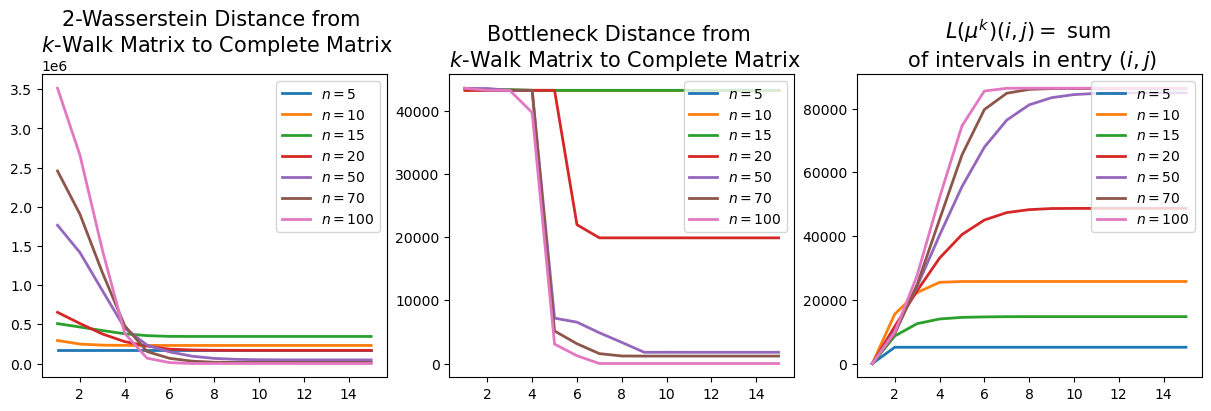

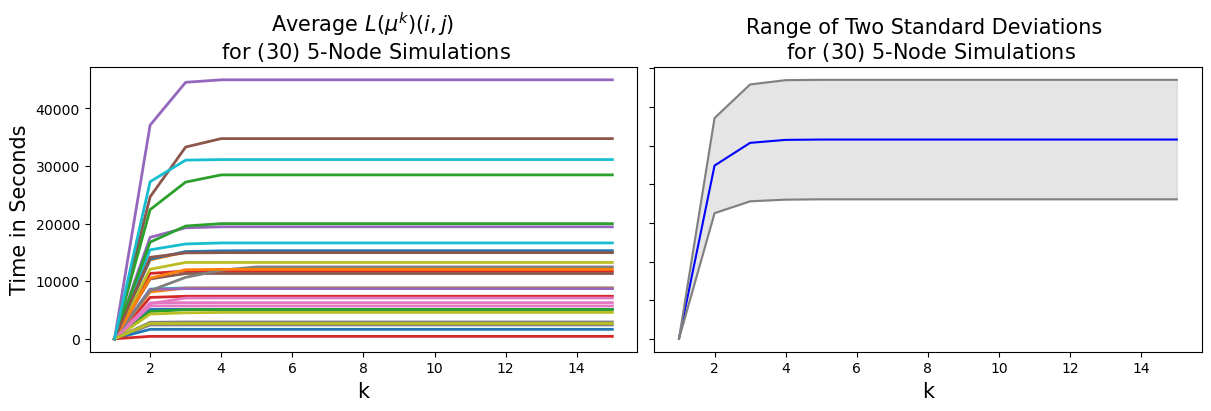

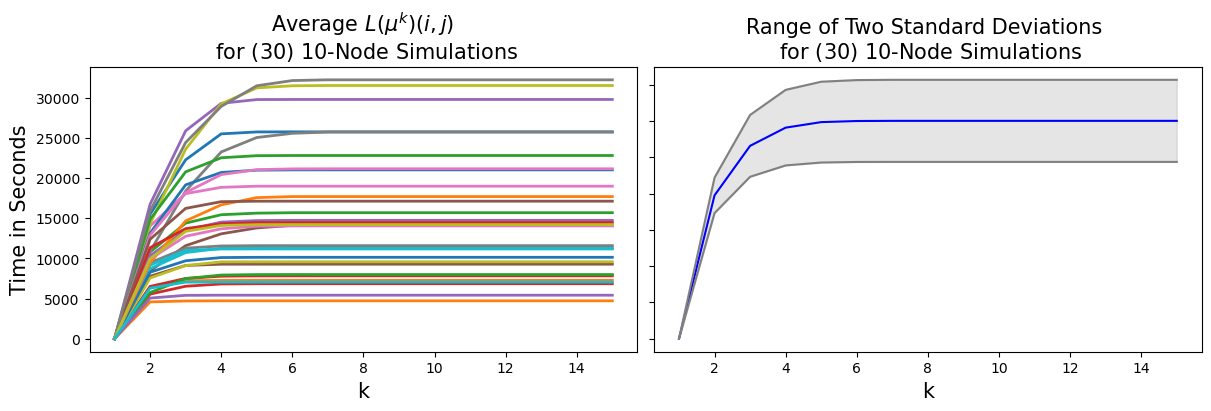

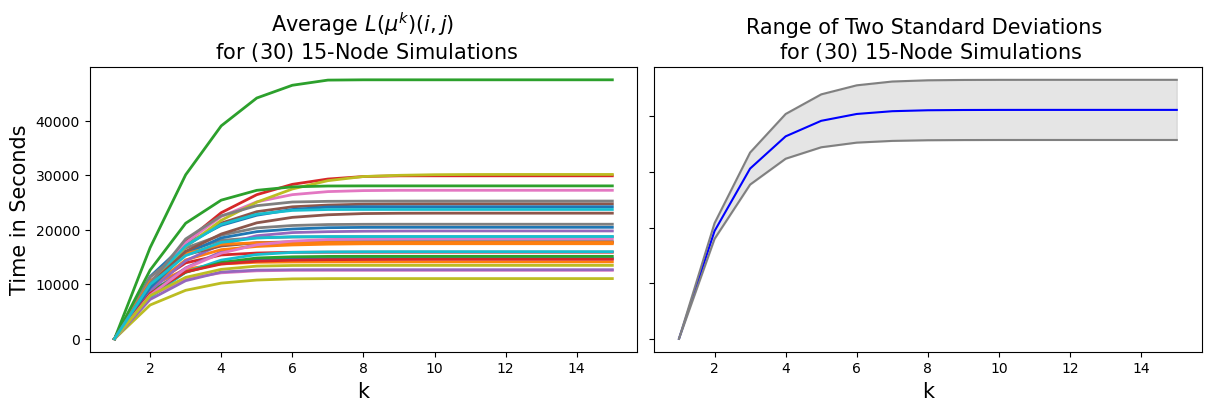

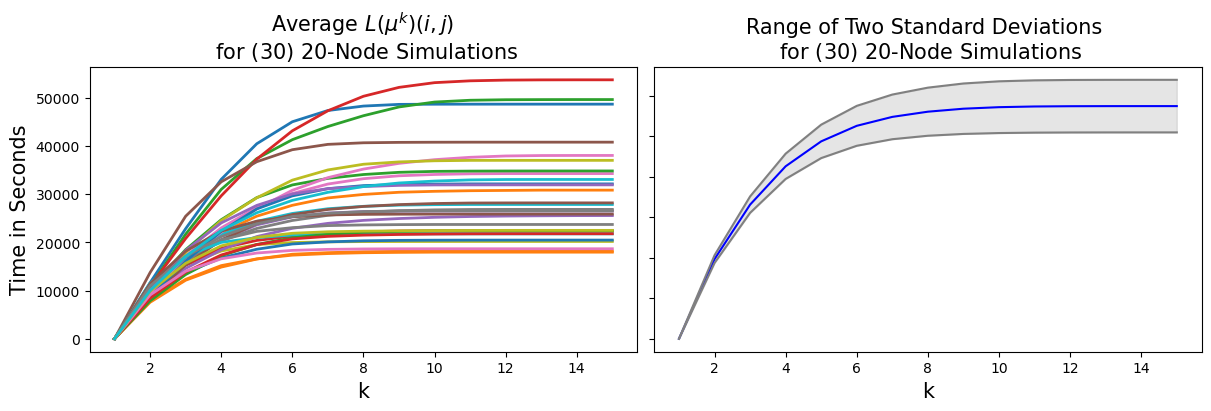

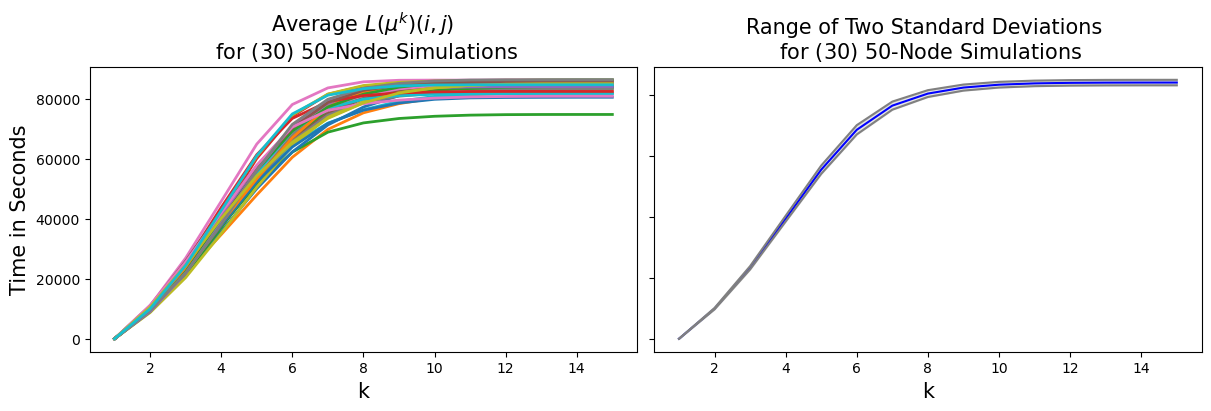

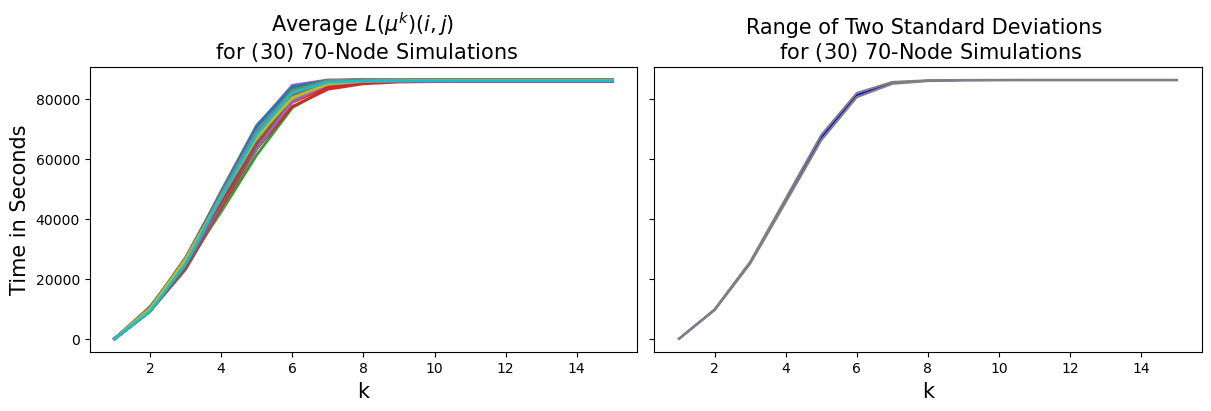

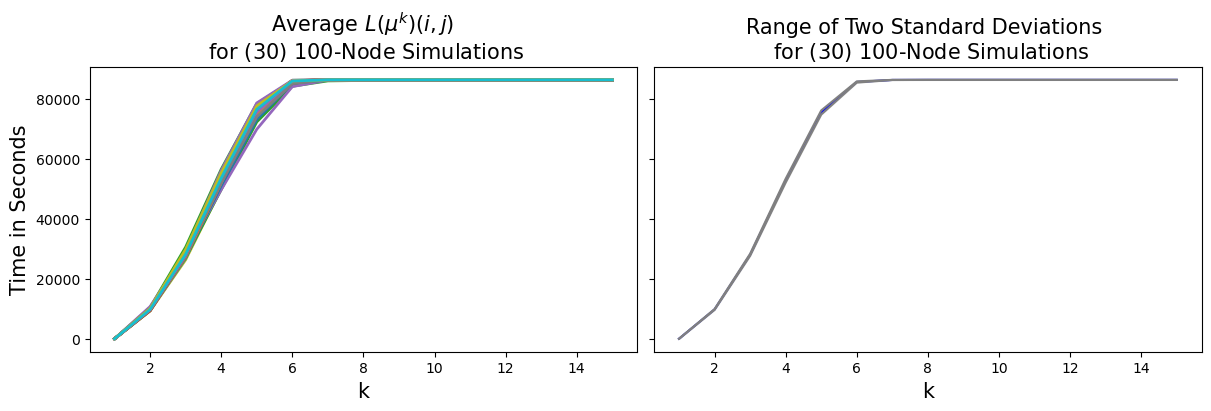

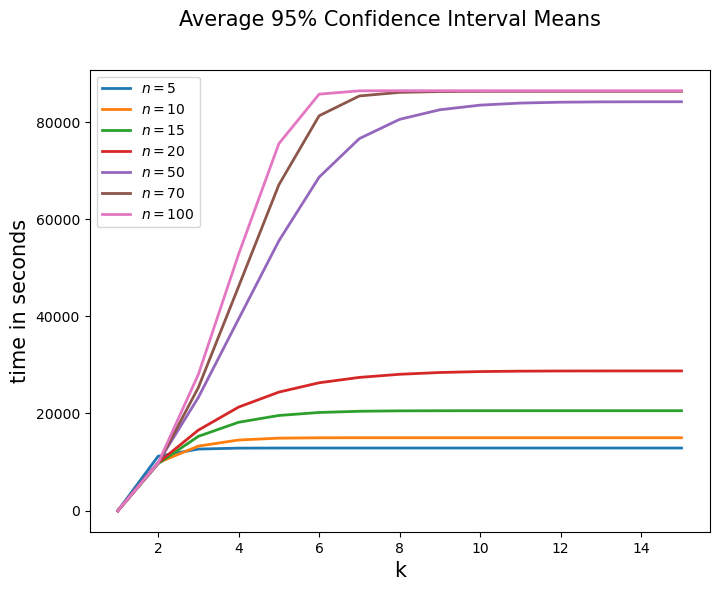

In [3]:
n_list = [20, 30, 40, 50, 70, 100] # Figure 5, 7
# n_list = [5, 10, 15, 20, 25, 30, 35, 40] # Figure 8
n_list = [5, 10, 15, 20, 50, 70, 100]
simulation_count = 30
# simulation_count = 2

date = datetime.now()
print(f"Running Lifetime Matrix Simulations on Date = {date}")

print(f"Generating ORB Files")

folder_names = []
orb_paths = [[] for n in n_list]
for i, n in enumerate(n_list):
    
    folder_name = f"lt-starlink-{n}-sat-single"
    folder_names.append(folder_name)
    make_folder(f"{folder_base}/{folder_name}")

    # Generate Earth Simulations
    for j in range(simulation_count):
        name = f"starlink_{date.strftime('%Y_%m')}_{j}"
        orb_filename = generate_orb_files(
            folder_name, 
            name, 
            sample_sats(starlink, n),
            date)
            
        orb_path = f"{folder_base}/{folder_name}/{orb_filename}"
        orb_paths[i].append(orb_path)

orb_paths_flat = [path for path in itertools.chain.from_iterable(orb_paths)]

print("Running SOAP on ORB files")
su.run_soap_mac(orb_paths_flat, max_workers=10)

print(f"Constructing Matrices from ORB Files")
A = [[] for n in n_list]
B = [[] for n in n_list]
m = [[] for n in n_list] # dimensions of the matrices
max_diameter = [[] for n in n_list]
max_diameter_time = [[] for n in n_list]
max_diameter_sg = [[] for n in n_list]

for i, n in enumerate(n_list):
    folder_name = folder_names[i]
    # diagrams[i] = {}
    dim_sum = 0
    for j, path in enumerate(tqdm(orb_paths[i])):
        orb_filename = path.replace(".orb", "").split("/")[-1]
        filepath = path.replace(".orb", " Contact Analysis.csv")

        matrix = rp.soap_converter(filepath)
        A[i].append(matrix)
        B[i].append(IntervalMatrix.complete_matrix(matrix.dim_row))
        m[i].append(matrix.dim_row)

        contact_plan = rp.contact_analysis_parser(filepath)
        tvg = rp.construct_graph(contact_plan, delta = 1)
        critical_times = rp.extract_critical_times(tvg)
        sample_times = rp.sample_critical_times(critical_times)

        diameter, time, sg = sanx.get_max_diameter(tvg, sample_times)

        max_diameter[i].append(diameter)
        max_diameter_time[i].append(time)
        max_diameter_sg[i].append(sg)

        sanx.save_figure(sg, 
            f"{folder_base}/{folder_name}/{orb_filename}_max_graph_diameter.png")

        dim_sum += matrix.dim_row

    print(f"Average Dimension of {n}-Satellite TVG Matrices is {dim_sum / len(orb_paths[i])}")
    print(f"The maximum diameter over {len(orb_paths[i])} is {max(max_diameter[i])}")

print(f"Calculating Walks")

start_time, end_time = 0, 86400

walk_length = max([max(max_diameter[i]) for i in range(len(n_list))])
print(f"Calculating walks up to k = {walk_length}")

walks = [[] for n in n_list]

# for i, n in enumerate([]):
for i, n in enumerate(n_list):
    folder_name = folder_names[i]
    
    print(f"Calculating Walks for {len(orb_paths[i])} {n}-Satellite Systems")
    for j, path in enumerate(tqdm(orb_paths[i])):
        orb_filename = path.replace(".orb", "").split("/")[-1]
        walks[i].append([IntervalMatrix.identity_matrix(m[i][j])])

        adjacency_matrices_max_diameter = []

        # print(f"Calculating Walks for {j}-th {n}-Satellite System")
        for k in range(walk_length):
            # print("\tCalculating {}-Walks for {}-th {}-Sat system".format(k, i, n))
            if k == 0:
                A_k = A[i][j]
            else:
                A_k = A[i][j] * walks[i][j][-1]

            tvg_slice = A_k.get_slice_at(max_diameter_time[i][j])
            adjacency_matrices_max_diameter.append(np.array(tvg_slice))

            walks[i][j].append(A_k)

        filepath = f"{folder_base}/{folder_name}/{orb_filename}_heatmap.gif"
        if max_diameter[i][j] > 1:
            save_heatmap_gif(adjacency_matrices_max_diameter, m[i][j], max_diameter[i][j], filepath)

# Calculating Distances
print(f"Calculating Distances")
lifetime_list = [[] for n in n_list]
bdist = [None for n in n_list]
wdist_2 = [None for n in n_list]

for i, n in enumerate(n_list):
    bdist[i] = [None for j in orb_paths[i]]
    wdist_2[i] = [None for j in orb_paths[i]]

    for j, path in enumerate(tqdm(orb_paths[i])):
        bdist[i][j] = [-1 for k in range(1, walk_length)]
        wdist_2[i][j] = [-1 for k in range(1, walk_length)]

        # print(f"{i}:{j} : {path}")

        for k in range(1, walk_length):
            A_k = walks[i][j][k]
            B_k = B[i][j]
            # B_k = IntervalMatrix.complete_matrix(n)

            diagram_a_k = tvg_to_complement_diagram_matrix(A_k, start_time, end_time)
            diagram_b_k = tvg_to_complement_diagram_matrix(B_k, start_time, end_time)

            distance = tvg_interval_bottleneck_distance_matrix(diagram_a_k, diagram_b_k, m[i][j])
            bdist[i][j][k - 1] = sup_norm(distance)

            distance = tvg_interval_wasserstein_distance_matrix(diagram_a_k, diagram_b_k, m[i][j], 2)
            wdist_2[i][j][k - 1] = q_norm(distance, 2)

        # Lifetime Matrix
        L = tvg_lifetime_matrix(walks[i][j], start_time, end_time, walk_length)

        y_list = generate_y_list(L, walks[i][j][0].dim_row, walk_length)
        y_list_average = calculate_y_list_average(y_list, walk_length)
        lifetime_list[i].append(y_list_average)

# Plot Aggregates
print(f"Plotting Aggregates Overlay and Confidence Interval")

x = list(range(1, walk_length))

# Plot Wasserstein and Bottleneck Distances to Complete Matrices (First, j=0)
fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(12, 4))
axs[0].set_title(f"2-Wasserstein Distance from \n $k$-Walk Matrix to Complete Matrix", fontsize=15)
axs[1].set_title(f"Bottleneck Distance from \n $k$-Walk Matrix to Complete Matrix", fontsize=15)
axs[2].set_title(f"$L(\mu^k)(i, j) = $ sum \n of intervals in entry $(i, j)$", fontsize=15)

for i, n in enumerate(n_list):
    distance = wdist_2[i][0]
    axs[0].plot(x, distance, linewidth=2, label=f"$n = {n}$")

    distance = bdist[i][0]
    axs[1].plot(x, distance, linewidth=2, label=f"$n = {n}$")

    coverage = lifetime_list[i][0][1:]
    axs[2].plot(x, coverage, linewidth=2, label=f"$n = {n}$")

axs[0].legend(loc="upper right")
axs[1].legend(loc="upper right")
axs[2].legend(loc="upper right")

plt.savefig(f"{folder_base}/algebraic_distances_overlay_today_test.png")
plt.show()

# Plot Lifetime Distances and Confidence Intervals
mean_list = [[] for n in n_list]
for i, n in enumerate(n_list):
    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))

    # axs[0].set_xlabel("k", fontsize=15)
    # axs[0].set_ylabel('Time in Seconds', fontsize=15)
    axs[0].set_title(f"Average $L(\mu^k)(i, j)$ \n for $({len(orb_paths[i])})$ ${n}$-Node Simulations", fontsize=15)

    # ax1.plot(x, lifetime_list[i][0][1:], linewidth=2) # plot first only
    for j, path in enumerate(orb_paths[i]):
        axs[0].plot(x, lifetime_list[i][j][1:], linewidth=2)
    # labels.append(f"$n = {n}$")

    lower_list = []
    upper_list = []

    for k in range(1, walk_length):
        data = []
        for j in range(1, len(lifetime_list[i])):
            data.append(lifetime_list[i][j][k])
        # mean, lower, upper = confidence_interval(data)
        mean, lower, upper = error_bars(data)
        
        mean_list[i].append(mean)
        lower_list.append(lower)
        upper_list.append(upper)

    # axs[1].set_xlabel("k", fontsize=15)
    # axs[1].set_ylabel("Time in Seconds", fontsize=15)
    axs[1].set_title(f"Range of Two Standard Deviations \n for $({len(orb_paths[i])})$ {n}-Node Simulations", fontsize=15)

    axs[1].plot(x, mean_list[i], color="blue")
    axs[1].plot(x, lower_list, color="grey")
    axs[1].plot(x, upper_list, color="grey")

    for ax in axs.flat:
        ax.set_xlabel("k", fontsize=15)
        ax.set_ylabel("Time in Seconds", fontsize=15)

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

    plt.fill_between(x, lower_list, upper_list, color='grey', alpha=0.2)
    plt.savefig(f"{folder_base}/average_lifetime_matrix_{n}_sats_today.png")
    plt.show()

labels = []
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.set_xlabel("k", fontsize=15)
ax.set_ylabel("time in seconds", fontsize=15)
fig.suptitle("Average 95% Confidence Interval Means", fontsize=15)
for i, n in enumerate(n_list):
    labels.append(f"$n = {n}$")
    ax.plot(x, mean_list[i], linewidth=2)
plt.legend(labels)
plt.savefig(f"{folder_base}/average_lifetime_matrix_aggregates_today.png")
plt.show()

Running KNN Simulations on Date = 2023-04-03 10:51:30.102574


INFO:soap_utilities:Running `run_soap_mac` with 500 simulations on 10 threads.
INFO:soap_utilities:Running `execute_commands` with 500 commands and 2 hacks.


Running SOAP on ORB files


31:84: execution error: System Events got an error: Can’t set application process "SOAP" to false. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)
31:84: execution error: System Events got an error: Can’t set application process "SOAP" to false. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)
31:84: execution error: System Events got an error: Can’t set application process "SOAP" to false. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)
31:84: execution error: System Events got an error: Can’t set application process "SOAP" to false. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)
31:84: execution error: System Events got an error: Can’t set application process "SOAP" to false. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to 

Average Points in Dgm[1] is 176.34
Average Points in Dgm[1] is 424.5
Average Points in Dgm[1] is 712.5
Average Points in Dgm[1] is 1508.5
Average Points in Dgm[1] is 4412.38
Calculating 5 instances of `distance_matrix_function`


100%|██████████| 5/5 [3:30:25<00:00, 2525.14s/it]


Calculating Accuracies Single 80:20 Split for each `n`


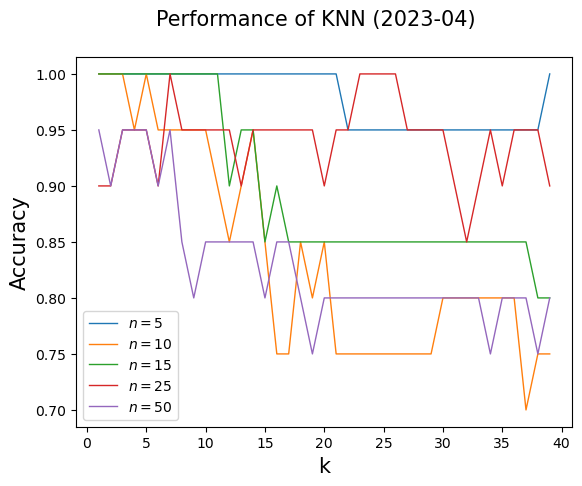

Calculating Accuracies 100 80:20 Splits for each `n`


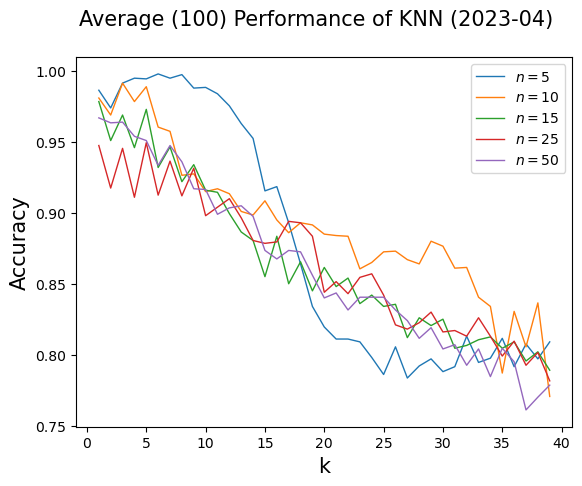

In [4]:
n_list = [5, 10, 15, 25, 50]
# n_list = [5, 10, 15]
simulation_count = 50 # number of simulations to run for each `n`
# simulation_count = 5

date = datetime.now()
print(f"Running KNN Simulations on Date = {date}")

print(f"Generating ORB Files")

orb_paths = [[] for n in n_list]

for i, n in enumerate(n_list):
    folder_name = f"knn-starlink-{n}-moon-{simulation_count}-mars-{simulation_count}"
    make_folder(f"{folder_base}/{folder_name}")

    # Generate Earth / Moon Simulations
    for j in range(simulation_count):
        name = f"starlink_moon_{date.strftime('%Y-%m')}_{j}"
        orb_filename = generate_orb_files(
            folder_name, 
            name, 
            sample_sats(starlink, n) + moon_sats,
            date)

        orb_path = f"{folder_base}/{folder_name}/{orb_filename}"
        orb_paths[i].append(orb_path)

    # Generate Earth / Mars Simulations
    for j in range(simulation_count):
        name = f"starlink_mars_{date.strftime('%Y-%m')}_{j}"
        orb_filename = generate_orb_files(
            folder_name, 
            name, 
            sample_sats(starlink, n) + mars_sats,
            date)

        orb_path = f"{folder_base}/{folder_name}/{orb_filename}"
        orb_paths[i].append(orb_path)

orb_paths_flat = [path for path in itertools.chain.from_iterable(orb_paths)]

# for path in orb_paths_flat:
#     print(path)

print("Running SOAP on ORB files")
su.run_soap_mac(orb_paths_flat, max_workers=10)

EARTH, MOON, MARS = 0, 1, 2 # labels for KNN

diagrams = [{} for n in n_list]
x = [[] for n in n_list]
y = [[] for n in n_list]

for i, n in enumerate(n_list):
    # diagrams[i] = {}
    dgm_sum = 0
    for path in orb_paths[i]:
        filepath = path.replace(".orb", " Contact Analysis.csv")

        contact_plan = rp.contact_analysis_parser(filepath)
        graph = rp.construct_graph(contact_plan, delta = 1)    
        weighted_simplex = rp.construct_weighted_simplex(graph)
        
        zz, dgms, cells = calculate_zz_persistence(weighted_simplex)

        filename = filepath.split("/")[-1]

        diagrams[i][filename] = {
            "dgms" : dgms,
            "id" : len(x[i])
        }
        dgm_sum += len(dgms[1])

        x[i].append(filename)
        label = -1
        if "moon" in filename:
            label = MOON
        elif "mars" in filename:
            label = MARS
        else:
            label = EARTH

        y[i].append(label)

    print(f"Average Points in Dgm[1] is {dgm_sum / len(orb_paths[i])}")

dim = 1

print(f"Calculating {len(n_list)} instances of `distance_matrix_function`")

distance_matrix_functions = [None for n in n_list]
for i, n in enumerate(tqdm(n_list)):
    # print(f"\tCalculating `distance_matrix_function[{i}]`")
    distance_matrix_functions[i] = distance_matrix_lambda_function(diagrams[i], x[i], y[i], dim = dim)

print(f"Calculating Accuracies Single 80:20 Split for each `n`")

ks = range(1, 40)

accuracies = [[] for n in n_list]
for i, n in enumerate(n_list):
    x_train, x_test, y_train, y_test = train_test_split(x[i], y[i], test_size=0.2)
    
    for k in ks:
        knn = KNeighborsClassifier(distance_matrix_functions[i], k=k)
        knn.fit(x_train, y_train)
        accuracy = knn.evaluate(x_test, y_test)
        accuracies[i].append(accuracy)

fig, ax = plt.subplots()
labels = []
for i, n in enumerate(n_list):
    labels.append(f"$n = {n}$")
    ax.plot(ks, accuracies[i], linewidth=1)

ax.set_xlabel("k", fontsize=15)
ax.set_ylabel("Accuracy", fontsize=15)
fig.suptitle(f"Performance of KNN ({date.strftime('%Y-%m')})", fontsize=15)
plt.legend(labels)
plt.savefig(f"{folder_base}/knn_single_overlay_today.png")
plt.show()

m = 100 
print(f"Calculating Accuracies {m} 80:20 Splits for each `n`")

ks = range(1, 40)
accuracies = [[] for n in n_list]
for i, n in enumerate(n_list):
    for k in ks:
        k_accuracies = []
        for j in range(m):
            x_train, x_test, y_train, y_test = train_test_split(x[i], y[i], test_size=0.2)
            knn = KNeighborsClassifier(distance_matrix_functions[i], k=k)
            knn.fit(x_train, y_train)
            accuracy = knn.evaluate(x_test, y_test)
            # accuracies[i].append(accuracy)
            k_accuracies.append(accuracy)
        average = sum(k_accuracies) / len(k_accuracies)
        accuracies[i].append(average)

fig, ax = plt.subplots()
labels = []
for i, n in enumerate(n_list):
    labels.append(f"$n = {n}$")
    ax.plot(ks, accuracies[i], linewidth=1)

ax.set_xlabel("k", fontsize=15)
ax.set_ylabel("Accuracy", fontsize=15)
fig.suptitle(f"Average ({m}) Performance of KNN ({date.strftime('%Y-%m')})", fontsize=15)
plt.legend(labels)
plt.savefig(f"{folder_base}/knn_average_training_overlay_today.png")
plt.show()

### Slice Analysis

In [31]:
n_list = [50]
simulation_count = 30

date = datetime.now()
print(f"Running Slice Analysis Simulations on Date = {date}")

print(f"Generating ORB Files")

orb_paths = [[] for n in n_list]
for i, n in enumerate(n_list):
    
    folder_name = f"slice-starlink-{n}-sat-single"
    make_folder(f"{folder_base}/{folder_name}")

    # Generate Earth Simulations
    for j in range(simulation_count):
        name = f"starlink_{date.strftime('%Y-%m')}_{j}"
        orb_filename = generate_orb_files(
            folder_name, 
            name, 
            sample_sats(starlink, n),
            date)
            
        orb_path = f"{folder_base}/{folder_name}/{orb_filename}"
        orb_paths[i].append(orb_path)

orb_paths_flat = [path for path in itertools.chain.from_iterable(orb_paths)]

print("Running SOAP on ORB files")
su.run_soap_mac(orb_paths_flat, max_workers=10)

# critical_times = [None for n in n_list]
for i, n in enumerate(n_list):

    # critical_times[i] = [None for j in orb_paths[i]]
    for j, path in enumerate(orb_paths[i]):

        filepath = path.replace(".orb", " Contact Analysis.csv")

        contact_plan = rp.contact_analysis_parser(filepath)
        tvg = rp.construct_graph(contact_plan, delta = 1)
        # critical_times[i][j] = rp.extract_critical_times(graph)
        critical_times = rp.extract_critical_times(tvg)
        sample_times = rp.sample_critical_times(critical_times)

        diameters = []
        for time in sample_times:
            graph = sanx.get_graph_slice_at(tvg, time)
            diameters.append(sanx.get_diameter(graph))
            
        # print(f"NX : {n}-sats-{j} : (min,avg,max)=({min(diameters)},{sum(diameters)/len(diameters)},{max(diameters)})")
        print(f"NX : {n}-sats-{j} : max={max(diameters)} (out of {len(sample_times)} slices)")

        diameters = []
        for time in sample_times:
            graph = sagt.get_graph_slice_at(tvg, time)
            diameters.append(sagt.get_diameter(graph))

        # print(f"GT : {n}-sats-{j} : (min,avg,max)=({min(diameters)},{sum(diameters)/len(diameters)},{max(diameters)})")



Running Slice Analysis Simulations on Date = 2023-04-05 20:56:44.456107
Generating ORB Files
Running SOAP on ORB files
NX : 50-sats-0 : max=5 (out of 5012 slices)
NX : 50-sats-1 : max=7 (out of 5214 slices)
NX : 50-sats-2 : max=18 (out of 4282 slices)
NX : 50-sats-3 : max=5 (out of 5530 slices)
NX : 50-sats-4 : max=14 (out of 5533 slices)
NX : 50-sats-5 : max=9 (out of 5224 slices)
NX : 50-sats-6 : max=7 (out of 4701 slices)
NX : 50-sats-7 : max=14 (out of 5078 slices)
NX : 50-sats-8 : max=12 (out of 5173 slices)
NX : 50-sats-9 : max=9 (out of 5703 slices)
NX : 50-sats-10 : max=15 (out of 4754 slices)
NX : 50-sats-11 : max=7 (out of 4919 slices)
NX : 50-sats-12 : max=8 (out of 6004 slices)
NX : 50-sats-13 : max=20 (out of 4787 slices)
NX : 50-sats-14 : max=11 (out of 4748 slices)
NX : 50-sats-15 : max=10 (out of 4528 slices)
NX : 50-sats-16 : max=11 (out of 4808 slices)
NX : 50-sats-17 : max=6 (out of 5301 slices)
NX : 50-sats-18 : max=7 (out of 4138 slices)
NX : 50-sats-19 : max=9 (ou